Load Julia packages (libraries) needed

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain
gr(size=(500,800));

┌ Warning: Package Turing does not have CmdStan in its dependencies:
│ - If you have Turing checked out for development and have
│   added CmdStan as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Turing
│ Loading CmdStan into Turing from project dependency, future warnings for Turing are suppressed.
└ @ nothing nothing:840


CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "02")
cd(ProjDir)

Define the Stan language model

In [3]:
binomialstanmodel = "
// Inferring a Rate
data {
  int N;
  int<lower=0> k[N];
  int<lower=1> n[N];
}
parameters {
  real<lower=0,upper=1> theta;
  real<lower=0,upper=1> thetaprior;
}
model {
  // Prior Distribution for Rate Theta
  theta ~ beta(1, 1);
  thetaprior ~ beta(1, 1);

  // Observed Counts
  k ~ binomial(n, theta);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [4]:
stanmodel = Stanmodel(name="binomial", monitors = ["theta"], model=binomialstanmodel,
  output_format=:mcmcchain);
# Use 16 observations
N2 = 4^2
d = Binomial(9, 0.66)
n2 = Int.(9 * ones(Int, N2));

Show first 5 (generated) observations

In [5]:
k2 = rand(d, N2);
k2[1:5]

5-element Array{Int64,1}:
 6
 7
 6
 6
 6

Input data for cmdstan

In [6]:
binomialdata = Dict("N" => length(n2), "n" => n2, "k" => k2);

Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, binomialdata, ProjDir, diagnostics=false,
  CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)


Inference for Stan model: binomial_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (0.030, 0.029, 0.029, 0.029) seconds, 0.12 seconds total
Sampling took (0.049, 0.041, 0.044, 0.046) seconds, 0.18 seconds total

                Mean     MCSE  StdDev     5%   50%   95%    N_Eff  N_Eff/s    R_hat
lp__             -91  2.7e-02     1.1    -93   -91   -90  1.6e+03  9.1e+03  1.0e+00
accept_stat__   0.91  1.8e-03    0.12   0.64  0.95   1.0  4.7e+03  2.6e+04  1.0e+00
stepsize__      0.80  2.1e-02   0.030   0.76  0.83  0.83  2.0e+00  1.1e+01  2.6e+13
treedepth__      2.0  6.1e-02    0.70    1.0   2.0   3.0  1.3e+02  7.2e+02  1.0e+00
n_leapfrog__     4.8  3.4e-01     5.3    1.0   3.0    15  2.5e+02  1.4e+03  1.0e+00
divergent__     0.00      nan    0.00   0.00  0.00  0.00      nan      nan      nan
energy__          92  3.9e-02     1.5     90    92    95  1.5e+03  8.1e+03  1.0e+00
theta           0.70  6.5e-04   0.038  

Allocate array of Normal fits

In [8]:
fits = Vector{Normal{Float64}}(undef, 4)
for i in 1:4
  fits[i] = fit_mle(Normal, convert.(Float64, chn.value[:, 1, i]))
  println(fits[i])
end

Normal{Float64}(μ=0.7050443339999997, σ=0.03712601501481734)
Normal{Float64}(μ=0.7063177350000003, σ=0.03687032248520177)
Normal{Float64}(μ=0.7038097480000004, σ=0.03853384684583793)
Normal{Float64}(μ=0.7035539640000003, σ=0.03835334166847397)


Plot the 4 chains

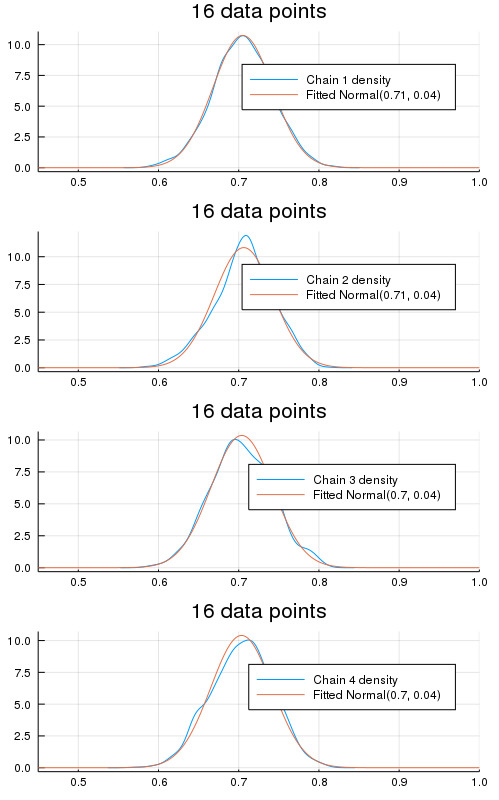

In [9]:
if rc == 0
  p = Vector{Plots.Plot{Plots.GRBackend}}(undef, 4)
  x = 0:0.001:1
  for i in 1:4
    vals = convert.(Float64, chn.value[:, 1, i])
    μ = round(fits[i].μ, digits=2)
    σ = round(fits[i].σ, digits=2)
    p[i] = density(vals, lab="Chain $i density",
       xlim=(0.45, 1.0), title="$(N2) data points")
    plot!(p[i], x, pdf.(Normal(fits[i].μ, fits[i].σ), x), lab="Fitted Normal($μ, $σ)")
  end
  plot(p..., layout=(4, 1))
end

End of `clip_08s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*